# An Example

All right, we hope that was a sufficiently grandiose introduction. Now it's time to get our hands dirty and work through an example. We'll start very simple and throughout the book delve deeper. 

This notebook loads up some actual measurements of the sun over time, cleans the data, and then uses machine learning techniques to fit those data. 

Specifically for the data, the observations are from the Solar Dynamics Observatory (SDO) Extreme Ultraviolet Variability Experiment (EVE) that measures all the light coming from the sun between 5 nanometers (nm) and 105 nm. We'll be working just with the measurements taken at 17.1 nm; light that is emitted from the Iron (Fe) IX ion in the corona, which only exists at a temperature of about 600,000 K -- a fairly moderate temperature for the solar corona. 

Specifically for the machine learning, we'll be using Support Vector Regression (SVR) and validation curves. Support Vector Machines (SVM) are typically used in a type of **classification**, an important category of machine learning that focuses on identifying and labeling groups in the data. SVMs can be extended to regression. There's some discussion of the function we'll be using [here](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) and [here](http://scikit-learn.org/stable/modules/svm.html#svm-regression). Validation curves are a way of quantifying the question: _which fit is the best fit?_ Data scientists are probably used to seeing things like reduced $\chi^2$. The purpose is the same, but these tools are built together in a python module we'll be using extensively, called [scikit-learn](http://scikit-learn.org/stable/). 

First we'll import all the stuff we're going to need, just to get that out of the way.

In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
from scipy.io.idl import readsav
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.svm import SVR
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Custom modules
from jpm_time_conversions import metatimes_to_seconds_since_start, datetimeindex_to_human

## Load and clean data

Next we will load up the data. You can download that dataset from [here](https://www.dropbox.com/s/hmrb6eajwv6g6ec/Example%20Dimming%20Light%20Curve.sav?dl=0) or from the HelioML folder containing this notebook and then just update the path below as necessary to point to it. We're using [pandas](https://pandas.pydata.org/) DataFrames largely because they are highly compatible with scikit-learn, as we'll see later. Finally, we'll use the ```head()``` function to take a quick look at the data. 

In [2]:
idl_generated_data = readsav('./Example Dimming Light Curve.sav')
light_curve_df = pd.DataFrame({'irradiance':idl_generated_data.irradiance.byteswap().newbyteorder(),  # [W/m^2]
                               'uncertainty':idl_generated_data.uncertainty.byteswap().newbyteorder()})  # [%]
light_curve_df.index = pd.DatetimeIndex(idl_generated_data.datetime.astype(str))
light_curve_df.head()

,irradiance,uncertainty
2012-04-16 17:43:20,0.246831,0.052733
2012-04-16 17:44:19,0.399922,0.085439
2012-04-16 17:45:18,0.275836,0.058930
2012-04-16 17:46:17,0.319487,0.068255
2012-04-16 17:47:16,0.920058,0.196561


Next we'll plot the data so we can get a quick idea of what we're working with. 

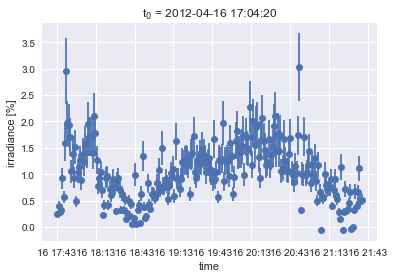

In [3]:
plt.errorbar(x=light_curve_df.index, 
             y=light_curve_df['irradiance'], 
             yerr=light_curve_df['uncertainty'], 
             fmt='o')
plt.title("t$_0$ = " + datetimeindex_to_human(light_curve_df.index)[0])
plt.xlabel('time')
plt.ylabel('irradiance [%]');

So sure, these are some measurements of ultraviolet light from the sun. But looking at it, it could be almost anything. It's just a time series. Your eye can naturally trace some basic shapes in the data; you can pretty easily see through the noise. But what we'd like is to have just that smooth curve. The original motivation that lead to the example was to be able to parameterize the depth and slope of that dip about a quarter of the way through; that's a coronal dimming and it contains information about a violent coronal mass ejection that resulted in some bad space weather. If interested, you can read the papers about this coronal dimming work [here](https://ui.adsabs.harvard.edu/#abs/2016SPD....4740402M/abstract) and [here](https://ui.adsabs.harvard.edu/#abs/2014ApJ...789...61M/abstract).

So we want to pull out the smooth curve underlying that data. There are plenty of traditional approaches to do this. We could smooth. We could fit polynomials. We could fit a spline. We chose this as a first example to help bridge the gap between the familiar and the probably less familiar machine learning method. Lets start with a little bit of code.

In [4]:
# Pull data out of the DataFrame for compatibility formatting
X = metatimes_to_seconds_since_start(light_curve_df.index)
y = light_curve_df['irradiance'].values

This X, y format is the standard when using nearly anything in scikit-learn. They've built a very nice, uniform application programming interface (API). In this particular case, it's pretty obvious that the X is time and y is the intensity. They are each 1 dimensional. But in general, this same syntax is used even when we have highly dimensional data. Each of the y dimensions is known as a **feature**, in machine learning parlance. We convert the times to seconds since start to avoid issues interpreting timestamps later.

Next we'll do a bit of cleaning. Most machine learning methods cannot accept missing data. You have to "impute", i.e., decide how you want to fill in those missing data. scikit-learn has a whole [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) tool for dealing with this. In our case, we'll just get rid of those missing data, marked by a NaN, since we still maintain the proper timing with our X axis. We'll also do a bit of shaping for compatibility with scikit-learn functions.

In [5]:
finite_irradiance_indices = np.isfinite(y)
X = X[finite_irradiance_indices]
X = X.reshape(len(X), 1)
uncertainty = light_curve_df['uncertainty'].values[np.isfinite(y)]
y = y[finite_irradiance_indices]

## Best fit determination

Here, we're just defining a quick helper function that we'll be using in the next section. We'll come back and explain this momentarily.

In [6]:
# Helper function for compatibility with validation_curve
def svr_pipe(gamma=5e-8, **kwargs):
    return make_pipeline(SVR(kernel='rbf', C=1e3, gamma=gamma, **kwargs))

Now to figure out which fit is going to be the best one, we still need to decide on what range we're going to test across. If this were a polynomial fit, we'd be talking about which polynomial orders we'd like to try fitting. In the case of SVR, that free parameter is called $\gamma$. Having some a priori knowledge of what range is sensible for this data, we'll generate an array of $\gamma$s to test. Another note of nomenclature, in machine learning, these are known as **hyper parameters*

In [7]:
gamma = np.logspace(-10, -5, num=20, base=10)

Another thing we'll need in order to determine which fit is best is a metric to do that scoring. scikit-learn has many options available. The default is R^2 but we'll overwrite that default with explained variance.

In [8]:
evs = make_scorer(explained_variance_score)

The last bit of prep before we can figure out which fit is best is to decide which data will be used to train the data and which will be used to score the fit. This concept is probably new to those who haven't dealt with machine learning before. It comes from one of the fundamental purposes of the discipline: prediction. If I'd like to validate my model without waiting for new data to come in (if new data are even still being generated), then I can simply allocate some of my existing data for training and treat the other chunk like new incoming data to validate and quantify how good the predictions are. Relatedly, a common problem is that if you fit _all_ of the data, your model will do a really good job of fitting that data, but do terrible with any new data. It's sort of like overfitting. We'll come back to that next, but first, lets just split the data 50/50. A shuffle split picks a uniformly random selection of data points. This way we can be sure our data still span the whole time series, instead of just picking e.g., the first quarter of data to train on. With the ```n_splits``` optional input, we can decide how many different sets we want to make. In other words, choose some random points to train on. Now choose another random set of points to train on. Repeat, repeat, repeat for as many times as you define with ```n_splits```. This helps make our results more robust. You can play around with how many splits you need to get final results (later) that don't vary much. We've already done that and found that 20 works pretty well. 

In [9]:
shuffle_split = ShuffleSplit(n_splits=20, train_size=0.5, test_size=0.5, random_state=None)

Now we can get to the validation curve. First we'll discuss the input, then run it, plot it, and discuss it. 

The first input makes use of our earlier helper function, ```svr_pipe()```. All this function does is make a pipeline around the SVR function. Pipelines in scikit-learn are pretty nifty. They result in an object that has the same API as any other model type, but allow you to wrap up a whole bunch of different methods together. For example, you could wrap up a bunch of pre-processing like Impute in here. In this case, our helper function is just allowing us to input a variety of $\gamma$s in a single call to validation curve. 

The next inputs are just the X and y arrays. Pretty straight forward. Next we define the name of the parameter that is going to be varied: $\gamma$ in this case. Models other than SVR would have other hyperparameters and may even have more than one. Then we pass in that array of different $\gamma$s to vary. 

Next we've got a few optional inputs. ```cv``` is the cross-validation strategy. This is where we can input our ```shuffle_split``` object just defined. ```n_jobs``` is a really nice and quick way to parallelize this work. Literally just pass in the number of parallel threads you want. Be careful using this out in the wild though. If you're building this into a bigger suite of code that is itself already running in parallel, you can end up actually slowing things down and get confusing results when each higher-level parallel thread try to spin off new threads for the validation curve. Then finally, we have ```scoring```, where we can input the explained variance object we defined earlier.

In [10]:
train_score, val_score = validation_curve(svr_pipe(), X, y,
                                          'svr__gamma',
                                          gamma, cv=shuffle_split, n_jobs=3, scoring=evs)

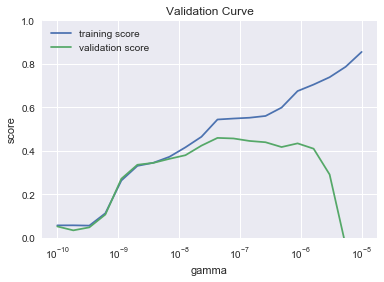

In [11]:
p1 = plt.semilogx(gamma, np.median(train_score, 1), label='training score')
p2 = plt.semilogx(gamma, np.median(val_score, 1), label='validation score')
plt.title('Validation Curve')
plt.xlabel('gamma')
plt.ylabel('score')
plt.ylim(0, 1)
plt.legend(loc='best');

This is a pretty iconic looking validation curve. The major common features are all there. The training score starts low for low values of the hyperparameter ($\gamma$ in this case for SVR). It then monotonically increases across the whole range. In other words, ever more complicated models do a better job of fitting the training data. Where things get interesting is when you look at the validation score. It too starts out low for low values of $\gamma$, but it is also low at very high $\gamma$. In the middle somewhere we find a peak. This tells us that a complicated model can do an excellent job with data it is trained on, but does terrible when that learned model is applied to new data. In more traditional terms, you can think of the gap between the training and validation score at high $\gamma$ as overfitting and the terrible scores at low $\gamma$ as underfitting. That peak in the middle is our best fit. So lets now programmatically grab that peak value of $\gamma$. Note that for each of the ```n_splits``` in our ```shuffle_split```, we have a different set of scores. That's why in the plot and below, we're taking a median across axis 1. 

In [12]:
scores = np.median(val_score, axis=1)
best_fit_score = np.max(scores)
best_fit_gamma = gamma[np.argmax(scores)]
print('Scores: {}'.format(str(scores)))
print('Best score: {}'.format(str(best_fit_score)))
print('Best fit gamma: {}'.format(str(best_fit_gamma)))

Scores: [ 0.05195524  0.03391803  0.04768922  0.10671474  0.27127605  0.33552685
  0.34430115  0.36286517  0.37951346  0.42362163  0.45909345  0.45650719
  0.44508229  0.43914381  0.41708402  0.43395816  0.40950255  0.29077434
 -0.03509505 -0.9674281 ]
Best score: 0.4590934471580122
Best fit gamma: 4.281332398719396e-08


## Explore! 
Here's a chance to play around with the tools you've seen so far. Here are some suggestions to try out: 
* Try different ranges of gamma and see what happens to the plot. 
* Try changing n_jobs to see how it affects processing time. Open up your Activity Monitor (macOS) or Task Manager (Windows) to see the multiple threads and their impact on your CPU usage. 
* Try different scoring methods. You can import [any of these different regression metrics](http://scikit-learn.org/stable/modules/classes.html#regression-metrics) (follow the import example at the top of the notebook) and feed them to the `make_scorer()` above. 
* Try a different number of splits (`n_splits`) in `ShuffleSplit()`.
* Try different `train_size` and `test_size` in `ShuffleSplit()`. 
* Try a totally different method of splitting the data between training and testing. You can import [any of these splitter classes](http://scikit-learn.org/stable/modules/classes.html#splitter-classes) (follow the import example at the top of the notebook) and use them in place of `ShuffleSplit()`.

You can use the cells below (and add more if you like) to produce new plots/best fit numbers and compare them. Or just use the cells as a scratch space. You are now a human learning machine learning.

## Fitting the data

Now that we've identified which gamma results in the best fit, we can actually run that fit on the data and include uncertainties as well. Unfortunately, validation curve doesn't let us pass uncertainties in yet, but there is [an active issue on the GitHub repository to do so](https://github.com/scikit-learn/scikit-learn/issues/10252). The API expects us to provide sample weight instead of uncertainty, so we just do an inverse. Then we run the SVR fit with our best gamma. Finally, we _predict_. This is the common parlance in machine learning but in this context what we're really getting back is the y values of the fit. 

In [13]:
sample_weight = 1 / uncertainty
model = SVR(kernel='rbf', C=1e3, gamma=best_fit_gamma).fit(X, y, sample_weight)
y_fit = model.predict(X)

Finally we can produce a nice plot showing our new machine-learning-identified best fit over the original data.

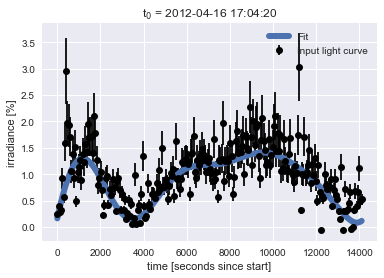

In [14]:
plt.errorbar(X.ravel(), y, yerr=uncertainty, color='black', fmt='o', label='Input light curve')
plt.plot(X.ravel(), y_fit, linewidth=6, label='Fit')
plt.title("t$_0$ = " + datetimeindex_to_human(light_curve_df.index)[0])
plt.xlabel('time [seconds since start]')
plt.ylabel('irradiance [%]')
plt.legend(loc='best');

## Explore! 
Here's another chance to see how your changes impact the final result: the fit to the data. Here's some suggestions: 
* Input your favorite number as the `best_fit_gamma` and see how the fit does.
* Try a different penalty parameter (`C`). The default value is 1.0. We used 1e3. 
* Try a different kernel. You can use any of [these kernels](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). Warning: be careful with the 'linear' kernel because it can take a long time to fit depending on the other parameters.
* Try modifying the `sample_weight` to see how that impacts the fit.

## Recap
In this example, we've used a familiar goal -- fitting a time series -- as a way to introduce some common machine learning concepts. In particular, we introduced data cleaning (e.g., ```Impute```), training vs validation/prediction data sets (e.g., ```shuffle_split```), and validation (e.g., ```validation_curve```). 